# 交易过程

## API设置

In [1]:
# -*- coding: utf-8 -*-
import concurrent
import requests
import json
import os
from retrying import retry
from tqdm import tqdm
import random
from concurrent.futures import ThreadPoolExecutor
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import pandas as pd
from datetime import datetime, timedelta
from datetime import datetime

import pyarrow.ipc as ipc
import pyarrow as pa
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# openai gpt model
api_endpoint = "https://api.ai-gaochao.cn/v1"
#api_key = ""
model="gpt-4o-2024-05-13"

def call_openai(api_endpoint, api_key, prompts,random_seeds, desc=""):
    url = f"{api_endpoint}/chat/completions"

    @retry(stop_max_attempt_number=5)
    def _send_post_request(url,prompt,random_seed):
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }

        payload = {
            "model": model,
            "messages": [
                {
                    'role': 'user',
                    'content': prompt
                },
            ]
        }
        # return prompt
        
        try:
            raw_response = requests.post(url, headers=headers, json=payload, verify=False)
            response_json = json.loads(raw_response.content.decode('utf-8'))

            raw_usage = response_json.get('usage', {})
            message_content = response_json.get('choices', [{}])[0].get('message', {}).get('content', '')

            response = {
                "prompt": prompt,
                "response": message_content,
                "usage": raw_usage,
                "origin_output":response_json,
                "random_seed":random_seed
            }

            tqdm.write(f"Prompt: {prompt}")
            tqdm.write(f"Response: {message_content}")
            tqdm.write(f"Usage: {raw_usage}")
        except Exception as e:
            # print(raw_response.content)
            tqdm.write(f'Error occurred: {e}. Retrying...')
            return ""
        return response

    threads = 50
    generations = []
    with tqdm(total=len(prompts), desc=desc) as pbar:
        def update(*args):
            pbar.update()
        
        with ThreadPoolExecutor(max_workers=threads) as executor:
            futures = []

            for prompt,random_seed in zip(prompts,random_seeds):
                futures.append(executor.submit(_send_post_request, url,prompt,random_seed))
            
            for future in futures:
                future.add_done_callback(update)
                
            for future in futures:
                generations.append(future.result())
    return generations


## 读取当日新闻，检索历史上最接近的5个query，通过LLMs给出action建议

### 风险偏好模式

In [2]:
import json
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re

def load_and_group_news_by_date(file_path):
    # 读取 JSON 文件
    with open(file_path, 'r', encoding='utf-8') as file:
        news_data = json.load(file)

    # 使用 defaultdict 按日期分组新闻
    news_by_date = defaultdict(list)

    # 遍历每一条新闻
    for article in news_data:
        # 提取发布日期，只保留日期部分 (yyyy-mm-dd)
        published_date = article['publishedAt'][:10]
        
        # 将新闻的标题和描述组合成一个字符串
        news_entry = f"Title: {article['title']}\nDescription: {article['description']}\n"
        
        # 按日期分组
        news_by_date[published_date].append(news_entry)

    return news_by_date

def load_exp_data(exp_file_path):
    # 读取 APPLE_EXP.json 文件并返回完整的数据（包含 Query 和其他字段）
    with open(exp_file_path, 'r', encoding='utf-8') as file:
        exp_data = json.load(file)
        
    # 确保 Query 字段是字符串，如果是列表，则将其连接为一个字符串
    for item in exp_data:
        if isinstance(item['Query'], list):  # 如果 Query 是列表
            item['Query'] = ', '.join(item['Query'])  # 将列表连接成字符串
        elif not isinstance(item['Query'], str):  # 如果不是字符串，直接转换成字符串
            item['Query'] = str(item['Query'])
    return exp_data

def get_top_k_similar_news(news, exp_data, top_k=5):
    # 提取所有的 Query 字段进行相似度计算，同时保留所有记录的完整数据
    queries = [item['Query'] for item in exp_data]

    # 使用 TF-IDF 向量化器将新闻内容和 Query 向量化
    vectorizer = TfidfVectorizer()
    
    # 将 news 和 queries 一起向量化，第一条是 news，剩下的是 queries
    tfidf_matrix = vectorizer.fit_transform([news] + queries)
    
    # 计算 news 和每个 query 之间的余弦相似度
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
    
    # 找出相似度最高的 top_k 条数据的索引
    top_k_indices = np.argsort(cosine_sim)[-top_k:][::-1]
    
    # 返回相似度最高的 top_k 条完整记录及其相似度
    top_k_results = [(exp_data[i], cosine_sim[i]) for i in top_k_indices]
    
    return top_k_results

def extract_action_and_reason(summary_string):
    # 将 summary_string 按行分割
    lines = summary_string.splitlines()

    # 第一行是Action，后面的是Reason
    if len(lines) > 0:
        # 提取第一行的数字，并映射到相应的 Action
        first_line = lines[0].strip()
    
        if first_line == 'A':
            action = 'Buy'
        elif first_line == 'B':
            action = 'Hold'
        elif first_line == 'C':
            action = 'Sell'
        else:
            action = None  # 如果第一行不是 1, 2, 3，则视为无效
    else:
        action = None

    # 提取 Reason，允许 Reason 后面有多行内容并且格式不统一，忽略换行符和大小写
    reason_match = re.search(r'Reason:\s*(.*)', summary_string, re.DOTALL | re.IGNORECASE)
    reason = reason_match.group(1).strip() if reason_match else "No reason found"

    return action, reason, first_line

def save_response_to_file(date, action, reason, file_path):
    # 将 response 按日期写入 txt 文件
    with open(file_path, 'a', encoding='utf-8') as file:
        file.write(f"Date: {date}\nAction: {action}\nReason: {reason}\n\n")

# 主程序
news_file_path = 'APPLE_Trading.json'
exp_file_path = 'APPLE_EXP.json'
response_file_path = 'responses_by_date_radical.txt'

# 加载新闻和 APPLE_EXP.json 的完整数据
news_by_date = load_and_group_news_by_date(news_file_path)
exp_data = load_exp_data(exp_file_path)

# 用来存储日期和相应的 Action
dates = []
actions = []

# 遍历每个日期的新闻，将同一天的新闻内容合并，然后计算与 APPLE_EXP.json 中 Query 的相似度
for date, news_list in news_by_date.items():
    # 合并同一天的所有新闻内容
    combined_news = " ".join(news_list)
    
    # 输出合并后的新闻内容
    print(f"Combined news for {date}:")
    print(combined_news)
    
    # 计算与 APPLE_EXP.json 中 Query 的余弦相似度，找出最相似的 5 条
    top_similar_queries = get_top_k_similar_news(combined_news, exp_data, top_k=5)
    
    # 输出相似度最高的 5 条完整记录，包括字段和相似度
    print("\nTop 5 similar records from APPLE_EXP.json based on cosine similarity:")
    for item, similarity in top_similar_queries:
        # 合并 Record 和 Cosine Similarity
        combined_output = f"Record: {json.dumps(item, indent=4)}\nCosine Similarity: {similarity:.4f}"
        print(combined_output)
    
    # 模拟调用函数生成最终总结（假设你有一个生成器函数）
    prompt = f"""
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
{combined_news}
I found the 5 closest news stories in history based on the similarity of today's events and gave an analysis of the day's ups and downs and the impact of that news on the day's stock price.
Below is the history of the news:{combined_output}
You need to combine the information I gave you and make a judgment call on the buy sell hold of the stock and give reasons why.
For the sake of ease of my subsequent data processing, if you think you should buy, then output A on the first line, if you think you should hold, then output B on the first line, and if you think you should sell, then output C on the first line.The first line is not allowed to have anything else other than these 3 letters.
Here is a sample example:
A
Reason:Based on the current news and historical data, several positive developments are likely to boost Apple's stock price. Here's a breakdown of key factors:

1. **Upcoming M1X MacBook Pro Launch**: The anticipated release of the M1X MacBook Pro models this month is generating excitement. The update to a more powerful M1X chip is expected to drive strong sales, indicating Apple's continued strength and innovation in the computing market.

2. **iPhone 13 Comparisons and Features**: Detailed comparisons and analysis of the iPhone 13 lineup highlight Apple’s technological advancements, such as ProMotion and improved camera systems. This publicity helps maintain consumer interest and drives sales.

3. **Apple Watch Series 7 Leak**: Real-world images and imminent pre-orders for the Apple Watch Series 7 suggest that launch excitement is building, and the new designs and features will likely drive further sales.

4. **Consistent Innovation**: Historical data shows a positive stock response to significant product upgrades (e.g., iPhone 13 Pro and 13 Pro Max). Apple's track record of incremental innovation keeps consumers and investors engaged.

5. **Analyst Insights**: Noted Apple analyst Ming-Chi Kuo’s information about no OLED iPad Air next year could suggest confidence in current product line-up strategies, reassuring investors about upcoming product cycles.

Investors are generally bullish due to these upcoming product releases and innovations, leading to sustained confidence in Apple’s market performance. As a result, the stock price is expected to benefit from these announcements, making it a strong candidate for buying..
    """

    # 调用函数生成最终总结
    generations = call_openai(api_endpoint, api_key, [prompt], [42], desc="Generating Final Summary")
    summary_string = generations[0]['response']

    # 提取 Action 和 Reason
    action, reason, num = extract_action_and_reason(summary_string)
    
    # 保存 response 到文件
    save_response_to_file(date, action, reason, response_file_path)
    
    # 将日期和 Action和num 存入列表
    dates.append(date)
    actions.append(action)


Combined news for 2024-05-01:
Title: Google Paid Apple $20 Billion in 2022 to Be Default Safari Search Engine
Description: Google paid Apple $20 billion in 2022 to be the default search engine for Safari on iPhone, iPad, and Mac, reports Bloomberg. The information was...
 Title: Everything New in the iOS 17.5 Beta
Description: Apple is currently testing iOS 17.5, the fifth major update to the iOS 17 operating system that came out last September. Like iOS 17.4, iOS 17.5...
 Title: Apple Watch Ultra 3 will be a boring update, top insider suggests
Description: While we expect great changes for the Apple Watch Series 10, it seems the new Apple Watch Ultra 3 will be a boring update. Here's why.
 Title: iOS 18 Calendar app update could finally make it useful on iPhone
Description: Ahead of the official iOS 18 announcement on June 10, a report says Apple will solve Calendar and Reminders apps' main issue.
 Title: Kuo: Apple Watch Ultra to Get 'Almost No' Hardware Upgrades This Year
Descriptio

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Google Paid Apple $20 Billion in 2022 to Be Default Safari Search Engine
Description: Google paid Apple $20 billion in 2022 to be the default search engine for Safari on iPhone, iPad, and Mac, reports Bloomberg. The information was...
 Title: Everything New in the iOS 17.5 Beta
Description: Apple is currently testing iOS 17.5, the fifth major update to the iOS 17 operating system that came out last September. Like iOS 17.4, iOS 17.5...
 Title: Apple Watch Ultra 3 will be a boring update, top insider suggests
Description: Whil

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple Vision Pro Launch Was A Success With Other Companies, As CEO Tim Cook Shares That Half Of Fortune 100 Companies Have Purchased The AR Headset
Description: The Apple Vision Pro demand may have reduced substantially, but the company’s earnings call revealed that it is a hit among other companies
 Title: Apple's Q2 2024 Earnings Call Takeaways
Description: Apple today held its earnings call for the second fiscal quarter of 2024 (first calendar quarter), with Apple CEO Tim Cook and Apple CFO Luca Maestri...
 Title: Apple ca

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Berkshire's profit plunges 64% on portfolio holdings as Buffett sells Apple
Description: Berkshire Hathaway says its first quarter profit plummeted on the paper value of its investments. At the same time, the company said Saturday that most of the businesses it owns outright did well.
 Title: Google I/O 2024 is the company's last shot to dominate mobile AI
Description: Apple won't be kept down in the AI race forever
 Title: It's been 30 years since Apple released this boldly innovative product
Description: One Apple device wa

Generating Final Summary: 100%|██████████| 1/1 [00:14<00:00, 15.00s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple TV+'s Sugar has one of the wildest TV plot twists of all time
Description: I don't think I've ever seen a show throw a plot curveball as truly insane as Sugar, Apple's detective drama starring Colin Farrell.
 Title: Apple Event This Week Expected to Last 'About 35 Minutes'
Description: Apple will be holding its first event of the year this Tuesday, May 7 at 7 a.m. Pacific Time, with a live stream to be available on Apple.com and on...
 Title: How to Watch the 'Let Loose' Apple Event on Tuesday, May 7
Description: Apple 

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple honors 50 students as it expands coding beyond engineers heading into WWDC 2024
Description: Exclusive: ZDNET spoke with winners as well as Apple executive Susan Prescott about this year's Swift Student Challenge.
 Title: NYPD academy graduates 576 NYC, MTA cops in latest class
Description: The NYPD academy on Monday graduated 576 new cops on Monday, including 33 who will join the MTA police force -- even as the city's PBA says more cops are still needed to patrol the Big Apple.
 Title: Apple TV+'s Severance will return

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: ‘Dark Matter’ review: Joel Edgerton stars in Blake Crouch’s Apple series with a bad case of multiverse madness
Description: “Dark Matter” takes another plunge into the madness of multiverses, operating on a more cerebral and down-to-earth level than the superhero epics that have explored it.
 Title: Instead of getting thinner, the upgrade iPads need is better oleophobic coating
Description: The Apple Pencil is great and all, but it demanded a sacrifice. And we can still feel the loss!
 Title: 256GB makes sense for the base iP

Generating Final Summary: 100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: The Apple Vision Pro may have tanked - but spatial computing is still the future, Deloitte says
Description: Spatial computing, or the blending of physical and digital worlds, is not just a sci fi pipe dream — it's the next level of interaction.
 Title: Apple apologizes for 'crushed' iPad Pro ad after widespread online blowback
Description: Apple is apologizing for its advertisement promoting its latest iPad Pro after widespread blowback online.
 Title: Apple Pencil Pro: All the New Features
Description: Apple this week debut

Generating Final Summary: 100%|██████████| 1/1 [00:15<00:00, 15.27s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple nears deal with OpenAI to power upcoming iPhone features with ChatGPT, says Bloomberg
Description: After also talking to Google about AI tech for iOS 18, Apple has closed in on an agreement with OpenAI.
 Title: Apple's Notes app might get an AI assistant that transcribes audio - everything we know so far
Description: Notes and Voice Memos might get AI integration with transcription abilities to save time and summaries.
 Title: This is the dumbest M4 iPad Pro complaint I’ve seen
Description: It will be interesting to see

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple's first unionized store voted to strike
Description: Staff at an Apple Store in Towson, Maryland, authorized a strike on Saturday
 Title: Galaxy S25 Ultra chipset to get faster clock speed in redesign
Description: Qualcomm will redesign the Snapdragon 8 Gen 4 after the Apple M4 performs very strongly on Geekbench.
 Title: New Apple TV+ Show Marks A Career First For Natalie Portman After 30 Years
Description: After 30 years in Hollywood, the incredibly prolific Academy Award-winning actor Natalie Portman is still having 

Generating Final Summary: 100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple iOS 17.5 now has alerts for unwanted trackers
Description: Apple is finally adding alerts for “unwanted trackers”. The new feature is part of the iOS 17.5 for the iPhone. The iPhone maker appears to have
 Title: Apple iOS 17.5 has alerts for “unwanted trackers” before Android
Description: Apple is finally adding alerts for “unwanted trackers”. The new feature is part of the iOS 17.5 for the iPhone. The iPhone maker appears to have
 Title: iPad Marketing VP: iPad and Mac are Complementary Devices, Not Competing Devices
D

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: NYPD looking for 'person of interest' in random attack on actor Steve Buscemi
Description: Police have identified a person of interest in the random slugging attack on "Boardwalk Empire" star Steve Buscemi last week, and are fanning out across the Big Apple looking for the brute.
 Title: Samsung matches Apple in customer satisfaction
Description: Samsung is one of the leading smartphone manufacturers in the world, producing millions of units per year. Android Authority reports that the South Korean
 Title: I'm building a Wind

Generating Final Summary: 100%|██████████| 1/1 [00:15<00:00, 15.57s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: 6 M4 iPad Pro features Apple didn't tell you
Description: With the M4 iPad Pro now available, we discovered hidden features and other secrets Apple kept from us after announcing the tablet.
 Title: There’s some Apple UI magic sprinkled into the Pencil Pro experience
Description: Now that the Apple Pencil Pro is in users’ hands, discoveries are being made about the finer details of its design.
 Title: iPhone Emulators on the App Store: Game Boy, N64, PS1, PSP, and More
Description: In April, Apple updated its guidelines to all

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: 5 must-watch movies & TV shows streaming right now
Description: Streaming right now: What to watch and the best of what's new on Netflix, Hulu, HBO Max, Disney+, Apple TV+, Peacock, and Paramount+.
 Title: iOS 18 is getting a major upgrade that solves a big problem for iPhone users
Description: The Vehicle Motion Cues feature from Apple will help passengers combat motion sickness with overlays that help our eyes understand the direction our bodies are moving.
 Title: 'iPhone 17 Slim' Could Move Rear Cameras to Top Center in B

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.82s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple will reportedly offer higher trade-in credit for old iPhones for the next two weeks
Description: According to Bloomberg’s Mark Gurman, Apple will be offering a little more than usual for some trade-ins starting next week in the US and Canada. That's as long as you're getting one of the iPhone 15 models.
 Title: Apple Plans to Launch Its Highest-End iPhone 17 Model With a 'Slim' Design, Will Sit Above The 'Pro Max' And Cost Even Higher
Description: Apple is expected to launch a new model in the iPhone 17 lineup with a 't

Generating Final Summary: 100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: iPhone 15 Pro gets a discount of over $300 for a limited time
Description: Get ready for jaw-dropping discounts on Apple's iPhone 15 Pro in China. Don't miss out on this limited-time offer
 Title: iOS 18 to Use AI to Summarize Notifications, Add to Calendar, and More
Description: Apple is poised to unveil an auto-summarization feature for notifications as part of a series of new artificial intelligence features in iOS 18,...
 Title: Apple Music's Ranking Of Nas' "Illmatic" On Their Top 100 Albums List Has Fans Outraged
Descri

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.79s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: This iPhone Setting Will Make It Easy To Switch Between Pages On Safari
Description: Safari, Apple's default web browser, may seem like a boring alternative to Google's Chrome. But it has some fun features specially built for the iPhone.
 Title: The New Surface Is Impressive, But It's Not an Apple Killer
Description: Microsoft emphasized how the Surface compared to the MacBook Air, equipped with the M3, but the M4 is on the horizon.
 Title: Best Memorial Day smartwatch deals: Garmin, Apple Watch & more
Description: These earl

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Next Emoji Coming to iOS Could Include Face With Eye Bags, Shovel, Fingerprint, Splatter and More
Description: Apple adds new emoji to the iPhone, iPad, Mac, and other devices regularly based on updates made to the emoji catalog by the Unicode Consortium, and...
 Title: Apple patents a foldable iPhone with ‘self-healing’ screen
Description: The patent doesn’t describe what Apple would use for its self-healing layer other than “a polymer or any other desired material having self-healing properties.”
 Title: iOS 18 Apple Music 

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.54s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple Releases Safari Technology Preview 195 With Bug Fixes and Performance Improvements
Description: Apple today released a new update for Safari Technology Preview, the experimental browser Apple first introduced in March 2016. Apple designed the...
 Title: Flappy Bird Marks Its 11th Year Anniversary When It Launched On Apple’s App Store Today And Took The Mobile Gaming World By Storm
Description: The iconic Flappy Bird launched today 11 years ago for the Apple App Store, so we take a trip down memory lane regarding this fa

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Shop Memorial Day sales on Amazon for deals on celeb-loved beauty, more
Description: Amazon's 2024 Memorial Day sale offers markdowns up to 40% off celebrity-loved beauty products, fashion finds, home decor and more from the likes of Apple and Dyson.
 Title: How to sell your old Apple Pencil or Magic Keyboard
Description: The Cult of Mac buyback program is a great place to sell your Apple Pencil or Magic Keyboard for iPad Pro when it's time to upgrade.
 Title: 5 must-watch movies & TV shows streaming right now
Description: St

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: 47+ best Amazon Memorial Day sales 2024
Description: Shop the best Amazon Memorial Day from brands like Dyson, Hydro Flask, Apple and Revlon.
 Title: shop bedding, home goods and more
Description: Shop the best Memorial Day deals across categories like mattresses, bedding, tech and more from brands like Brooklinen, Supergoop, Apple and Our Place.
 Title: Apple Watch Ultra 3: All the rumors you need to know
Description: All signs pointed to a new Apple Watch 3 device launching imminently, but it failed to make an appearance at

Generating Final Summary: 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Surface Pro 11 vs MacBook Air: Can Microsoft Copilot+ unseat Apple?
Description: The new Surface Pro 11 is seriously impressive, but is it worth considering over a laptop like the MacBook Air M3? Let's take a look.
 Title: The buckets of AI and where Nvidia is crushing it
Description: We have had a lot of AI news lately – product launches from OpenAI, Google, and Microsoft. Now we are just waiting for Apple and its upcoming...
 Title: Apple considers two large touchscreen sizes for MacBook [Updated]
Description: Apple's foldi

Generating Final Summary: 100%|██████████| 1/1 [00:16<00:00, 16.07s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: YouTube’s Playables doesn’t have the games to compete with Apple
Description: The free games on YouTube mobile recalls AddictingGames.com and Facebook Games, but it isn’t giving Apple Arcade or App store a run for its money.
 Title: Apple’s WWDC opportunity: how iOS 18 can make AI mainstream
Description: Apple has a unique opportunity with iOS 18 to take AI features to the masses in a way that hasn‘t happened quite yet.
 Title: NYC students are asked to participate in remote-learning simulation — on their day off
Description:

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Cramer explains why Nvidia's ballooning market cap has its skeptics
Description: If Nvidia keeps up its current growth pace, Cramer said it could soar past Apple and overtake Microsoft soon.
 Title: This might be a hint that Apple TV+ isn't done with Ted Lasso yet
Description: Is more Ted Lasso possibly in the works? Maybe as a spinoff? One actor's tweet has us feeling hopeful.
 Title: Apple TV Plus is finally coming to Android according to new report
Description: A new job listing from Apple looking for an Android engineer i

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]

Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a radical investor who believes that the higher the risk, the higher the return. When possible opportunities arise, you will not give up any chance. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Popular Apple And Beelink Mini PCs Are Even More Budget-Friendly Than Usual At Amazon
Description: Outfit your home office with a compact mini PC.
 Title: Start a smart apartment for cheap with these 7 Amazon deals from $7
Description: Just because you live in an apartment doesn't mean you can't benefit from smart home upgrades. Amazon's latest smart home device sale can help you control your place using the Alexa, Apple, Google, and Matter platforms.
 Title: 5 must-watch movies & TV shows streaming right now
Description: Str

Dates: ['2024-05-01', '2024-05-02', '2024-05-04', '2024-05-05', '2024-05-06', '2024-05-08', '2024-05-09', '2024-05-10', '2024-05-12', '2024-05-13', '2024-05-14', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20', '2024-05-21', '2024-05-23', '2024-05-24', '2024-05-25', '2024-05-27', '2024-05-28', '2024-05-29', '2024-05-31']
Actions: ['Buy', 'Buy', 'Sell', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Buy', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy']


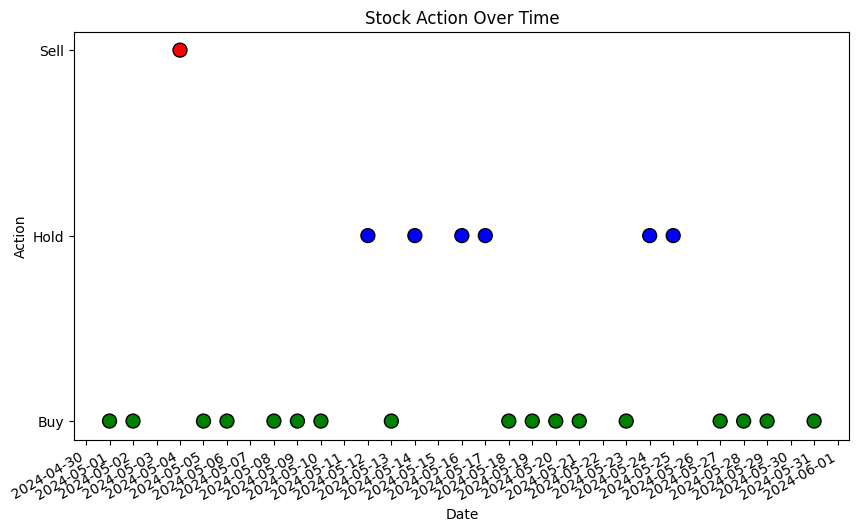

In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_actions(dates, actions):
    # 打印 dates 和 actions 列表
    print("Dates:", dates)
    print("Actions:", actions)
    
    # 映射 Action 到数值
    action_map = {'Buy': 1, 'Hold': 2, 'Sell': 3}
    colors_map = {'Buy': 'green', 'Hold': 'blue', 'Sell': 'red'}
    
    # 将日期和动作映射为数值和颜色
    numeric_actions = [action_map[action] for action in actions]
    colors = [colors_map[action] for action in actions]

    # 将日期转换为 datetime 对象，并确保只保留日期部分
    dates = [datetime.strptime(date, "%Y-%m-%d").date() for date in dates]

    # 创建图表
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(dates, numeric_actions, c=colors, s=100, edgecolor='black')

    # 设置图表标签和标题
    ax.set_yticks([1, 2, 3])
    ax.set_yticklabels(['Buy', 'Hold', 'Sell'])
    ax.set_title('Stock Action Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Action')

    # 使用 matplotlib.dates 格式化日期
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 设置日期格式
    ax.xaxis.set_major_locator(mdates.DayLocator())  # 按天显示日期

    # 自动旋转日期标签，避免重叠
    fig.autofmt_xdate()

    # 显示图表
    plt.show()
plot_actions(dates, actions)

Dates: ['2024-05-01', '2024-05-02', '2024-05-04', '2024-05-05', '2024-05-06', '2024-05-08', '2024-05-09', '2024-05-10', '2024-05-12', '2024-05-13', '2024-05-14', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20', '2024-05-21', '2024-05-23', '2024-05-24', '2024-05-25', '2024-05-27', '2024-05-28', '2024-05-29', '2024-05-31']
Actions: ['Buy', 'Buy', 'Sell', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Buy', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy']
2024-05-04 不是交易日，跳过该日期
2024-05-05 不是交易日，跳过该日期
2024-05-12 不是交易日，跳过该日期
2024-05-18 不是交易日，跳过该日期
2024-05-19 不是交易日，跳过该日期
2024-05-25 不是交易日，跳过该日期
2024-05-27 不是交易日，跳过该日期
图表已保存到 stock_actions_radical.png


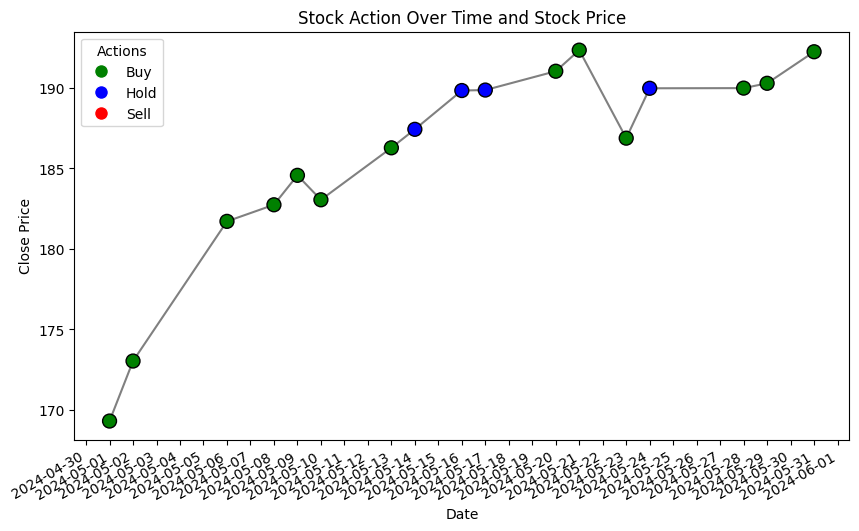

In [4]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 读取 Excel 文件
def read_apple_data(file_path):
    df = pd.read_excel(file_path)
    df['Date'] = pd.to_datetime(df['Date']).dt.date  # 转换为 datetime.date 类型
    return df

# 绘制图表函数
def plot_actions_with_stock(dates, actions, stock_data, save_path=None):
    # 打印 dates 和 actions 列表
    print("Dates:", dates)
    print("Actions:", actions)
    
    # 映射 Action 到数值
    action_map = {'Buy': 1, 'Hold': 2, 'Sell': 3}
    colors_map = {'Buy': 'green', 'Hold': 'blue', 'Sell': 'red'}
    
    # 将日期和动作映射为数值和颜色
    numeric_actions = [action_map[action] for action in actions]
    colors = [colors_map[action] for action in actions]

    # 将字符串日期转换为 datetime 对象
    dates = [datetime.strptime(date, "%Y-%m-%d").date() for date in dates]

    # 从 stock_data 中匹配日期并获取收盘价
    stock_dates = stock_data['Date'].values  # 获取股票数据的日期列

    # 过滤出存在于股票数据中的日期、动作和收盘价
    filtered_dates = []
    filtered_actions = []
    filtered_colors = []
    close_prices = []

    for i, date in enumerate(dates):
        if date in stock_dates:  # 如果日期在交易日数据中
            filtered_dates.append(date)
            filtered_actions.append(numeric_actions[i])
            filtered_colors.append(colors[i])
            close_price = stock_data.loc[stock_data['Date'] == date, 'Close'].values[0]
            close_prices.append(close_price)
        else:
            print(f"{date} 不是交易日，跳过该日期")

    # 创建图表
    fig, ax = plt.subplots(figsize=(10, 6))

    # 绘制折线图
    ax.plot(filtered_dates, close_prices, label="Close Price", color='gray', linestyle='-', marker='o', markersize=5)

    # 绘制散点图，并根据动作设置颜色
    ax.scatter(filtered_dates, close_prices, c=filtered_colors, s=100, edgecolor='black', zorder=5)

    # 设置图表标签和标题
    ax.set_title('Stock Action Over Time and Stock Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

    # 使用 matplotlib.dates 格式化日期
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 设置日期格式
    ax.xaxis.set_major_locator(mdates.DayLocator())  # 按天显示日期

    # 自动旋转日期标签，避免重叠
    fig.autofmt_xdate()
    # 添加图例，表示不同的动作
    buy_patch = plt.Line2D([0], [0], marker='o', color='w', label='Buy', markerfacecolor='green', markersize=10)
    hold_patch = plt.Line2D([0], [0], marker='o', color='w', label='Hold', markerfacecolor='blue', markersize=10)
    sell_patch = plt.Line2D([0], [0], marker='o', color='w', label='Sell', markerfacecolor='red', markersize=10)
    ax.legend(handles=[buy_patch, hold_patch, sell_patch], title="Actions")
    
    # 如果提供了保存路径，则保存图表到指定路径
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)  # 保存为 PNG 格式，DPI 设置为 300
        print(f"图表已保存到 {save_path}")

    # 显示图表
    plt.show()

# 主函数
def main():
    # 文件路径
    file_path = 'APPLE.XLSX'
    
    # 读取苹果股票数据
    stock_data = read_apple_data(file_path)
    # 保存图表的路径
    save_path = 'stock_actions_radical.png'

    
    # 调用绘图函数
    plot_actions_with_stock(dates, actions, stock_data, save_path)

# 执行主函数
main()

## 保守版本

In [5]:
import json
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re

def load_and_group_news_by_date(file_path):
    # 读取 JSON 文件
    with open(file_path, 'r', encoding='utf-8') as file:
        news_data = json.load(file)

    # 使用 defaultdict 按日期分组新闻
    news_by_date = defaultdict(list)

    # 遍历每一条新闻
    for article in news_data:
        # 提取发布日期，只保留日期部分 (yyyy-mm-dd)
        published_date = article['publishedAt'][:10]
        
        # 将新闻的标题和描述组合成一个字符串
        news_entry = f"Title: {article['title']}\nDescription: {article['description']}\n"
        
        # 按日期分组
        news_by_date[published_date].append(news_entry)

    return news_by_date

def load_exp_data(exp_file_path):
    # 读取 APPLE_EXP.json 文件并返回完整的数据（包含 Query 和其他字段）
    with open(exp_file_path, 'r', encoding='utf-8') as file:
        exp_data = json.load(file)
        
    # 确保 Query 字段是字符串，如果是列表，则将其连接为一个字符串
    for item in exp_data:
        if isinstance(item['Query'], list):  # 如果 Query 是列表
            item['Query'] = ', '.join(item['Query'])  # 将列表连接成字符串
        elif not isinstance(item['Query'], str):  # 如果不是字符串，直接转换成字符串
            item['Query'] = str(item['Query'])
    return exp_data

def get_top_k_similar_news(news, exp_data, top_k=5):
    # 提取所有的 Query 字段进行相似度计算，同时保留所有记录的完整数据
    queries = [item['Query'] for item in exp_data]

    # 使用 TF-IDF 向量化器将新闻内容和 Query 向量化
    vectorizer = TfidfVectorizer()
    
    # 将 news 和 queries 一起向量化，第一条是 news，剩下的是 queries
    tfidf_matrix = vectorizer.fit_transform([news] + queries)
    
    # 计算 news 和每个 query 之间的余弦相似度
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
    
    # 找出相似度最高的 top_k 条数据的索引
    top_k_indices = np.argsort(cosine_sim)[-top_k:][::-1]
    
    # 返回相似度最高的 top_k 条完整记录及其相似度
    top_k_results = [(exp_data[i], cosine_sim[i]) for i in top_k_indices]
    
    return top_k_results

def extract_action_and_reason(summary_string):
    # 将 summary_string 按行分割
    lines = summary_string.splitlines()

    # 确保至少有一行文本
    if len(lines) > 0:
        # 提取第一行的数字，并映射到相应的 Action
        first_line = lines[0].strip()
    
        if first_line == 'A':
            action = 'Buy'
        elif first_line == 'B':
            action = 'Hold'
        elif first_line == 'C':
            action = 'Sell'
        else:
            action = None  # 如果第一行不是 1, 2, 3，则视为无效
    else:
        action = None

    # 提取 Reason，允许 Reason 后面有多行内容并且格式不统一
    reason_match = re.search(r'Reason:\s*(.*)', summary_string, re.DOTALL | re.IGNORECASE)
    reason = reason_match.group(1).strip() if reason_match else "No reason found"

    return action, reason, first_line

def save_response_to_file(date, action, reason, file_path):
    # 将 response 按日期写入 txt 文件
    with open(file_path, 'a', encoding='utf-8') as file:
        file.write(f"Date: {date}\nAction: {action}\nReason: {reason}\n\n")

# 主程序
news_file_path = 'APPLE_Trading.json'
exp_file_path = 'APPLE_EXP.json'
response_file_path = 'responses_by_date_conservative.txt'

# 加载新闻和 APPLE_EXP.json 的完整数据
news_by_date = load_and_group_news_by_date(news_file_path)
exp_data = load_exp_data(exp_file_path)

# 用来存储日期和相应的 Action
dates = []
actions = []

# 遍历每个日期的新闻，将同一天的新闻内容合并，然后计算与 APPLE_EXP.json 中 Query 的相似度
for date, news_list in news_by_date.items():
    # 合并同一天的所有新闻内容
    combined_news = " ".join(news_list)
    
    # 输出合并后的新闻内容
    print(f"Combined news for {date}:")
    print(combined_news)
    
    # 计算与 APPLE_EXP.json 中 Query 的余弦相似度，找出最相似的 5 条
    top_similar_queries = get_top_k_similar_news(combined_news, exp_data, top_k=5)
    
    # 输出相似度最高的 5 条完整记录，包括字段和相似度
    print("\nTop 5 similar records from APPLE_EXP.json based on cosine similarity:")
    for item, similarity in top_similar_queries:
        # 合并 Record 和 Cosine Similarity
        combined_output = f"Record: {json.dumps(item, indent=4)}\nCosine Similarity: {similarity:.4f}"
        print(combined_output)
    
    # 模拟调用函数生成最终总结（假设你有一个生成器函数）
    prompt = f"""
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
{combined_news}
I found the 5 closest news stories in history based on the similarity of today's events and gave an analysis of the day's ups and downs and the impact of that news on the day's stock price.
Below is the history of the news:{combined_output}
You need to combine the information I gave you and make a judgment call on the buy sell hold of the stock and give reasons why.
For the sake of ease of my subsequent data processing, if you think you should buy, then output A on the first line, if you think you should hold, then output B on the first line, and if you think you should sell, then output C on the first line.The first line is not allowed to have anything else other than these 3 letters.
Here is a sample example:
A
Reason:Based on the current news and historical data, several positive developments are likely to boost Apple's stock price. Here's a breakdown of key factors:

1. **Upcoming M1X MacBook Pro Launch**: The anticipated release of the M1X MacBook Pro models this month is generating excitement. The update to a more powerful M1X chip is expected to drive strong sales, indicating Apple's continued strength and innovation in the computing market.

2. **iPhone 13 Comparisons and Features**: Detailed comparisons and analysis of the iPhone 13 lineup highlight Apple’s technological advancements, such as ProMotion and improved camera systems. This publicity helps maintain consumer interest and drives sales.

3. **Apple Watch Series 7 Leak**: Real-world images and imminent pre-orders for the Apple Watch Series 7 suggest that launch excitement is building, and the new designs and features will likely drive further sales.

4. **Consistent Innovation**: Historical data shows a positive stock response to significant product upgrades (e.g., iPhone 13 Pro and 13 Pro Max). Apple's track record of incremental innovation keeps consumers and investors engaged.

5. **Analyst Insights**: Noted Apple analyst Ming-Chi Kuo’s information about no OLED iPad Air next year could suggest confidence in current product line-up strategies, reassuring investors about upcoming product cycles.

Investors are generally bullish due to these upcoming product releases and innovations, leading to sustained confidence in Apple’s market performance. As a result, the stock price is expected to benefit from these announcements, making it a strong candidate for buying..
    """

    # 调用函数生成最终总结
    generations = call_openai(api_endpoint, api_key, [prompt], [42], desc="Generating Final Summary")
    summary_string = generations[0]['response']

    # 提取 Action 和 Reason
    action, reason, num = extract_action_and_reason(summary_string)
    
    # 保存 response 到文件
    save_response_to_file(date, action, reason, response_file_path)
    
    # 将日期和 Action和num 存入列表
    dates.append(date)
    actions.append(action)


Combined news for 2024-05-01:
Title: Google Paid Apple $20 Billion in 2022 to Be Default Safari Search Engine
Description: Google paid Apple $20 billion in 2022 to be the default search engine for Safari on iPhone, iPad, and Mac, reports Bloomberg. The information was...
 Title: Everything New in the iOS 17.5 Beta
Description: Apple is currently testing iOS 17.5, the fifth major update to the iOS 17 operating system that came out last September. Like iOS 17.4, iOS 17.5...
 Title: Apple Watch Ultra 3 will be a boring update, top insider suggests
Description: While we expect great changes for the Apple Watch Series 10, it seems the new Apple Watch Ultra 3 will be a boring update. Here's why.
 Title: iOS 18 Calendar app update could finally make it useful on iPhone
Description: Ahead of the official iOS 18 announcement on June 10, a report says Apple will solve Calendar and Reminders apps' main issue.
 Title: Kuo: Apple Watch Ultra to Get 'Almost No' Hardware Upgrades This Year
Descriptio

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Google Paid Apple $20 Billion in 2022 to Be Default Safari Search Engine
Description: Google paid Apple $20 billion in 2022 to be the default search engine for Safari on iPhone, iPad, and Mac, reports Bloomberg. The information was...
 Title: Everything New in the iOS 17.5 Beta
Description: Apple is currently testing iOS 17.5, the fifth major update to the iOS 17 operating system that came out last September. Like iOS 17.4, iOS 17.5...
 Title: Apple Watch Ultra 3 will be a boring update, top insider suggests
Description: W

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple Vision Pro Launch Was A Success With Other Companies, As CEO Tim Cook Shares That Half Of Fortune 100 Companies Have Purchased The AR Headset
Description: The Apple Vision Pro demand may have reduced substantially, but the company’s earnings call revealed that it is a hit among other companies
 Title: Apple's Q2 2024 Earnings Call Takeaways
Description: Apple today held its earnings call for the second fiscal quarter of 2024 (first calendar quarter), with Apple CEO Tim Cook and Apple CFO Luca Maestri...
 Title: Apple

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Berkshire's profit plunges 64% on portfolio holdings as Buffett sells Apple
Description: Berkshire Hathaway says its first quarter profit plummeted on the paper value of its investments. At the same time, the company said Saturday that most of the businesses it owns outright did well.
 Title: Google I/O 2024 is the company's last shot to dominate mobile AI
Description: Apple won't be kept down in the AI race forever
 Title: It's been 30 years since Apple released this boldly innovative product
Description: One Apple device

Generating Final Summary: 100%|██████████| 1/1 [00:08<00:00,  8.36s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple TV+'s Sugar has one of the wildest TV plot twists of all time
Description: I don't think I've ever seen a show throw a plot curveball as truly insane as Sugar, Apple's detective drama starring Colin Farrell.
 Title: Apple Event This Week Expected to Last 'About 35 Minutes'
Description: Apple will be holding its first event of the year this Tuesday, May 7 at 7 a.m. Pacific Time, with a live stream to be available on Apple.com and on...
 Title: How to Watch the 'Let Loose' Apple Event on Tuesday, May 7
Description: App

Generating Final Summary: 100%|██████████| 1/1 [00:06<00:00,  6.55s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple honors 50 students as it expands coding beyond engineers heading into WWDC 2024
Description: Exclusive: ZDNET spoke with winners as well as Apple executive Susan Prescott about this year's Swift Student Challenge.
 Title: NYPD academy graduates 576 NYC, MTA cops in latest class
Description: The NYPD academy on Monday graduated 576 new cops on Monday, including 33 who will join the MTA police force -- even as the city's PBA says more cops are still needed to patrol the Big Apple.
 Title: Apple TV+'s Severance will ret

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.54s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: ‘Dark Matter’ review: Joel Edgerton stars in Blake Crouch’s Apple series with a bad case of multiverse madness
Description: “Dark Matter” takes another plunge into the madness of multiverses, operating on a more cerebral and down-to-earth level than the superhero epics that have explored it.
 Title: Instead of getting thinner, the upgrade iPads need is better oleophobic coating
Description: The Apple Pencil is great and all, but it demanded a sacrifice. And we can still feel the loss!
 Title: 256GB makes sense for the base

Generating Final Summary: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: The Apple Vision Pro may have tanked - but spatial computing is still the future, Deloitte says
Description: Spatial computing, or the blending of physical and digital worlds, is not just a sci fi pipe dream — it's the next level of interaction.
 Title: Apple apologizes for 'crushed' iPad Pro ad after widespread online blowback
Description: Apple is apologizing for its advertisement promoting its latest iPad Pro after widespread blowback online.
 Title: Apple Pencil Pro: All the New Features
Description: Apple this week de

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple nears deal with OpenAI to power upcoming iPhone features with ChatGPT, says Bloomberg
Description: After also talking to Google about AI tech for iOS 18, Apple has closed in on an agreement with OpenAI.
 Title: Apple's Notes app might get an AI assistant that transcribes audio - everything we know so far
Description: Notes and Voice Memos might get AI integration with transcription abilities to save time and summaries.
 Title: This is the dumbest M4 iPad Pro complaint I’ve seen
Description: It will be interesting to 

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple's first unionized store voted to strike
Description: Staff at an Apple Store in Towson, Maryland, authorized a strike on Saturday
 Title: Galaxy S25 Ultra chipset to get faster clock speed in redesign
Description: Qualcomm will redesign the Snapdragon 8 Gen 4 after the Apple M4 performs very strongly on Geekbench.
 Title: New Apple TV+ Show Marks A Career First For Natalie Portman After 30 Years
Description: After 30 years in Hollywood, the incredibly prolific Academy Award-winning actor Natalie Portman is still havi

Generating Final Summary: 100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple iOS 17.5 now has alerts for unwanted trackers
Description: Apple is finally adding alerts for “unwanted trackers”. The new feature is part of the iOS 17.5 for the iPhone. The iPhone maker appears to have
 Title: Apple iOS 17.5 has alerts for “unwanted trackers” before Android
Description: Apple is finally adding alerts for “unwanted trackers”. The new feature is part of the iOS 17.5 for the iPhone. The iPhone maker appears to have
 Title: iPad Marketing VP: iPad and Mac are Complementary Devices, Not Competing Device

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: NYPD looking for 'person of interest' in random attack on actor Steve Buscemi
Description: Police have identified a person of interest in the random slugging attack on "Boardwalk Empire" star Steve Buscemi last week, and are fanning out across the Big Apple looking for the brute.
 Title: Samsung matches Apple in customer satisfaction
Description: Samsung is one of the leading smartphone manufacturers in the world, producing millions of units per year. Android Authority reports that the South Korean
 Title: I'm building a W

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.99s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: 6 M4 iPad Pro features Apple didn't tell you
Description: With the M4 iPad Pro now available, we discovered hidden features and other secrets Apple kept from us after announcing the tablet.
 Title: There’s some Apple UI magic sprinkled into the Pencil Pro experience
Description: Now that the Apple Pencil Pro is in users’ hands, discoveries are being made about the finer details of its design.
 Title: iPhone Emulators on the App Store: Game Boy, N64, PS1, PSP, and More
Description: In April, Apple updated its guidelines to 

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: 5 must-watch movies & TV shows streaming right now
Description: Streaming right now: What to watch and the best of what's new on Netflix, Hulu, HBO Max, Disney+, Apple TV+, Peacock, and Paramount+.
 Title: iOS 18 is getting a major upgrade that solves a big problem for iPhone users
Description: The Vehicle Motion Cues feature from Apple will help passengers combat motion sickness with overlays that help our eyes understand the direction our bodies are moving.
 Title: 'iPhone 17 Slim' Could Move Rear Cameras to Top Center i

Generating Final Summary: 100%|██████████| 1/1 [00:05<00:00,  5.73s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple will reportedly offer higher trade-in credit for old iPhones for the next two weeks
Description: According to Bloomberg’s Mark Gurman, Apple will be offering a little more than usual for some trade-ins starting next week in the US and Canada. That's as long as you're getting one of the iPhone 15 models.
 Title: Apple Plans to Launch Its Highest-End iPhone 17 Model With a 'Slim' Design, Will Sit Above The 'Pro Max' And Cost Even Higher
Description: Apple is expected to launch a new model in the iPhone 17 lineup with a

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.79s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: iPhone 15 Pro gets a discount of over $300 for a limited time
Description: Get ready for jaw-dropping discounts on Apple's iPhone 15 Pro in China. Don't miss out on this limited-time offer
 Title: iOS 18 to Use AI to Summarize Notifications, Add to Calendar, and More
Description: Apple is poised to unveil an auto-summarization feature for notifications as part of a series of new artificial intelligence features in iOS 18,...
 Title: Apple Music's Ranking Of Nas' "Illmatic" On Their Top 100 Albums List Has Fans Outraged
Des

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: This iPhone Setting Will Make It Easy To Switch Between Pages On Safari
Description: Safari, Apple's default web browser, may seem like a boring alternative to Google's Chrome. But it has some fun features specially built for the iPhone.
 Title: The New Surface Is Impressive, But It's Not an Apple Killer
Description: Microsoft emphasized how the Surface compared to the MacBook Air, equipped with the M3, but the M4 is on the horizon.
 Title: Best Memorial Day smartwatch deals: Garmin, Apple Watch & more
Description: These e

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Next Emoji Coming to iOS Could Include Face With Eye Bags, Shovel, Fingerprint, Splatter and More
Description: Apple adds new emoji to the iPhone, iPad, Mac, and other devices regularly based on updates made to the emoji catalog by the Unicode Consortium, and...
 Title: Apple patents a foldable iPhone with ‘self-healing’ screen
Description: The patent doesn’t describe what Apple would use for its self-healing layer other than “a polymer or any other desired material having self-healing properties.”
 Title: iOS 18 Apple Mus

Generating Final Summary: 100%|██████████| 1/1 [00:05<00:00,  5.26s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple Releases Safari Technology Preview 195 With Bug Fixes and Performance Improvements
Description: Apple today released a new update for Safari Technology Preview, the experimental browser Apple first introduced in March 2016. Apple designed the...
 Title: Flappy Bird Marks Its 11th Year Anniversary When It Launched On Apple’s App Store Today And Took The Mobile Gaming World By Storm
Description: The iconic Flappy Bird launched today 11 years ago for the Apple App Store, so we take a trip down memory lane regarding this

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Shop Memorial Day sales on Amazon for deals on celeb-loved beauty, more
Description: Amazon's 2024 Memorial Day sale offers markdowns up to 40% off celebrity-loved beauty products, fashion finds, home decor and more from the likes of Apple and Dyson.
 Title: How to sell your old Apple Pencil or Magic Keyboard
Description: The Cult of Mac buyback program is a great place to sell your Apple Pencil or Magic Keyboard for iPad Pro when it's time to upgrade.
 Title: 5 must-watch movies & TV shows streaming right now
Description:

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.62s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: 47+ best Amazon Memorial Day sales 2024
Description: Shop the best Amazon Memorial Day from brands like Dyson, Hydro Flask, Apple and Revlon.
 Title: shop bedding, home goods and more
Description: Shop the best Memorial Day deals across categories like mattresses, bedding, tech and more from brands like Brooklinen, Supergoop, Apple and Our Place.
 Title: Apple Watch Ultra 3: All the rumors you need to know
Description: All signs pointed to a new Apple Watch 3 device launching imminently, but it failed to make an appearance

Generating Final Summary: 100%|██████████| 1/1 [00:15<00:00, 15.08s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Surface Pro 11 vs MacBook Air: Can Microsoft Copilot+ unseat Apple?
Description: The new Surface Pro 11 is seriously impressive, but is it worth considering over a laptop like the MacBook Air M3? Let's take a look.
 Title: The buckets of AI and where Nvidia is crushing it
Description: We have had a lot of AI news lately – product launches from OpenAI, Google, and Microsoft. Now we are just waiting for Apple and its upcoming...
 Title: Apple considers two large touchscreen sizes for MacBook [Updated]
Description: Apple's fo

Generating Final Summary: 100%|██████████| 1/1 [00:05<00:00,  5.40s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: YouTube’s Playables doesn’t have the games to compete with Apple
Description: The free games on YouTube mobile recalls AddictingGames.com and Facebook Games, but it isn’t giving Apple Arcade or App store a run for its money.
 Title: Apple’s WWDC opportunity: how iOS 18 can make AI mainstream
Description: Apple has a unique opportunity with iOS 18 to take AI features to the masses in a way that hasn‘t happened quite yet.
 Title: NYC students are asked to participate in remote-learning simulation — on their day off
Descripti

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Cramer explains why Nvidia's ballooning market cap has its skeptics
Description: If Nvidia keeps up its current growth pace, Cramer said it could soar past Apple and overtake Microsoft soon.
 Title: This might be a hint that Apple TV+ isn't done with Ted Lasso yet
Description: Is more Ted Lasso possibly in the works? Maybe as a spinoff? One actor's tweet has us feeling hopeful.
 Title: Apple TV Plus is finally coming to Android according to new report
Description: A new job listing from Apple looking for an Android enginee

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.88s/it]

Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a conservative investor who particularly wants to avoid risks. Your ability to bear risks is limited, try to avoid risky decisions as much as possible. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Popular Apple And Beelink Mini PCs Are Even More Budget-Friendly Than Usual At Amazon
Description: Outfit your home office with a compact mini PC.
 Title: Start a smart apartment for cheap with these 7 Amazon deals from $7
Description: Just because you live in an apartment doesn't mean you can't benefit from smart home upgrades. Amazon's latest smart home device sale can help you control your place using the Alexa, Apple, Google, and Matter platforms.
 Title: 5 must-watch movies & TV shows streaming right now
Description: 

Dates: ['2024-05-01', '2024-05-02', '2024-05-04', '2024-05-05', '2024-05-06', '2024-05-08', '2024-05-09', '2024-05-10', '2024-05-12', '2024-05-13', '2024-05-14', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20', '2024-05-21', '2024-05-23', '2024-05-24', '2024-05-25', '2024-05-27', '2024-05-28', '2024-05-29', '2024-05-31']
Actions: ['Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold']
2024-05-04 不是交易日，跳过该日期
2024-05-05 不是交易日，跳过该日期
2024-05-12 不是交易日，跳过该日期
2024-05-18 不是交易日，跳过该日期
2024-05-19 不是交易日，跳过该日期
2024-05-25 不是交易日，跳过该日期
2024-05-27 不是交易日，跳过该日期
图表已保存到 stock_actions_conservative.png


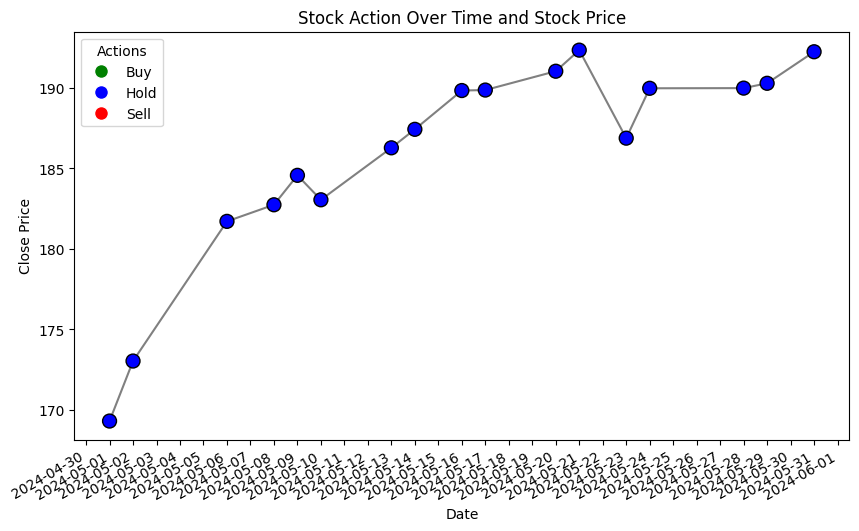

In [6]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 读取 Excel 文件
def read_apple_data(file_path):
    df = pd.read_excel(file_path)
    df['Date'] = pd.to_datetime(df['Date']).dt.date  # 转换为 datetime.date 类型
    return df

# 绘制图表函数
def plot_actions_with_stock(dates, actions, stock_data, save_path=None):
    # 打印 dates 和 actions 列表
    print("Dates:", dates)
    print("Actions:", actions)
    
    # 映射 Action 到数值
    action_map = {'Buy': 1, 'Hold': 2, 'Sell': 3}
    colors_map = {'Buy': 'green', 'Hold': 'blue', 'Sell': 'red'}
    
    # 将日期和动作映射为数值和颜色
    numeric_actions = [action_map[action] for action in actions]
    colors = [colors_map[action] for action in actions]

    # 将字符串日期转换为 datetime 对象
    dates = [datetime.strptime(date, "%Y-%m-%d").date() for date in dates]

    # 从 stock_data 中匹配日期并获取收盘价
    stock_dates = stock_data['Date'].values  # 获取股票数据的日期列

    # 过滤出存在于股票数据中的日期、动作和收盘价
    filtered_dates = []
    filtered_actions = []
    filtered_colors = []
    close_prices = []

    for i, date in enumerate(dates):
        if date in stock_dates:  # 如果日期在交易日数据中
            filtered_dates.append(date)
            filtered_actions.append(numeric_actions[i])
            filtered_colors.append(colors[i])
            close_price = stock_data.loc[stock_data['Date'] == date, 'Close'].values[0]
            close_prices.append(close_price)
        else:
            print(f"{date} 不是交易日，跳过该日期")

    # 创建图表
    fig, ax = plt.subplots(figsize=(10, 6))

    # 绘制折线图
    ax.plot(filtered_dates, close_prices, label="Close Price", color='gray', linestyle='-', marker='o', markersize=5)

    # 绘制散点图，并根据动作设置颜色
    ax.scatter(filtered_dates, close_prices, c=filtered_colors, s=100, edgecolor='black', zorder=5)

    # 设置图表标签和标题
    ax.set_title('Stock Action Over Time and Stock Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

    # 使用 matplotlib.dates 格式化日期
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 设置日期格式
    ax.xaxis.set_major_locator(mdates.DayLocator())  # 按天显示日期

    # 自动旋转日期标签，避免重叠
    fig.autofmt_xdate()

    # 添加图例，表示不同的动作
    buy_patch = plt.Line2D([0], [0], marker='o', color='w', label='Buy', markerfacecolor='green', markersize=10)
    hold_patch = plt.Line2D([0], [0], marker='o', color='w', label='Hold', markerfacecolor='blue', markersize=10)
    sell_patch = plt.Line2D([0], [0], marker='o', color='w', label='Sell', markerfacecolor='red', markersize=10)
    ax.legend(handles=[buy_patch, hold_patch, sell_patch], title="Actions")
    
    # 如果提供了保存路径，则保存图表到指定路径
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)  # 保存为 PNG 格式，DPI 设置为 300
        print(f"图表已保存到 {save_path}")

    # 显示图表
    plt.show()

# 主函数
def main():
    # 文件路径
    file_path = 'APPLE.XLSX'
    
    # 读取苹果股票数据
    stock_data = read_apple_data(file_path)
    # 保存图表的路径
    save_path = 'stock_actions_conservative.png'

    
    # 调用绘图函数
    plot_actions_with_stock(dates, actions, stock_data, save_path)

# 执行主函数
main()

## 正常风格

In [7]:
import json
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re

def load_and_group_news_by_date(file_path):
    # 读取 JSON 文件
    with open(file_path, 'r', encoding='utf-8') as file:
        news_data = json.load(file)

    # 使用 defaultdict 按日期分组新闻
    news_by_date = defaultdict(list)

    # 遍历每一条新闻
    for article in news_data:
        # 提取发布日期，只保留日期部分 (yyyy-mm-dd)
        published_date = article['publishedAt'][:10]
        
        # 将新闻的标题和描述组合成一个字符串
        news_entry = f"Title: {article['title']}\nDescription: {article['description']}\n"
        
        # 按日期分组
        news_by_date[published_date].append(news_entry)

    return news_by_date

def load_exp_data(exp_file_path):
    # 读取 APPLE_EXP.json 文件并返回完整的数据（包含 Query 和其他字段）
    with open(exp_file_path, 'r', encoding='utf-8') as file:
        exp_data = json.load(file)
        
    # 确保 Query 字段是字符串，如果是列表，则将其连接为一个字符串
    for item in exp_data:
        if isinstance(item['Query'], list):  # 如果 Query 是列表
            item['Query'] = ', '.join(item['Query'])  # 将列表连接成字符串
        elif not isinstance(item['Query'], str):  # 如果不是字符串，直接转换成字符串
            item['Query'] = str(item['Query'])
    return exp_data

def get_top_k_similar_news(news, exp_data, top_k=5):
    # 提取所有的 Query 字段进行相似度计算，同时保留所有记录的完整数据
    queries = [item['Query'] for item in exp_data]

    # 使用 TF-IDF 向量化器将新闻内容和 Query 向量化
    vectorizer = TfidfVectorizer()
    
    # 将 news 和 queries 一起向量化，第一条是 news，剩下的是 queries
    tfidf_matrix = vectorizer.fit_transform([news] + queries)
    
    # 计算 news 和每个 query 之间的余弦相似度
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
    
    # 找出相似度最高的 top_k 条数据的索引
    top_k_indices = np.argsort(cosine_sim)[-top_k:][::-1]
    
    # 返回相似度最高的 top_k 条完整记录及其相似度
    top_k_results = [(exp_data[i], cosine_sim[i]) for i in top_k_indices]
    
    return top_k_results

def extract_action_and_reason(summary_string):
    # 将 summary_string 按行分割
    lines = summary_string.splitlines()

    # 确保至少有一行文本
    if len(lines) > 0:
        # 提取第一行的数字，并映射到相应的 Action
        first_line = lines[0].strip()
    
        if first_line == 'A':
            action = 'Buy'
        elif first_line == 'B':
            action = 'Hold'
        elif first_line == 'C':
            action = 'Sell'
        else:
            action = None  # 如果第一行不是 1, 2, 3，则视为无效
    else:
        action = None

    # 提取 Reason，允许 Reason 后面有多行内容并且格式不统一
    reason_match = re.search(r'Reason:\s*(.*)', summary_string, re.DOTALL | re.IGNORECASE)
    reason = reason_match.group(1).strip() if reason_match else "No reason found"

    return action, reason, first_line

def save_response_to_file(date, action, reason, file_path):
    # 将 response 按日期写入 txt 文件
    with open(file_path, 'a', encoding='utf-8') as file:
        file.write(f"Date: {date}\nAction: {action}\nReason: {reason}\n\n")

# 主程序
news_file_path = 'APPLE_Trading.json'
exp_file_path = 'APPLE_EXP.json'
response_file_path = 'responses_by_date_normal.txt'

# 加载新闻和 APPLE_EXP.json 的完整数据
news_by_date = load_and_group_news_by_date(news_file_path)
exp_data = load_exp_data(exp_file_path)

# 用来存储日期和相应的 Action
dates = []
actions = []

# 遍历每个日期的新闻，将同一天的新闻内容合并，然后计算与 APPLE_EXP.json 中 Query 的相似度
for date, news_list in news_by_date.items():
    # 合并同一天的所有新闻内容
    combined_news = " ".join(news_list)
    
    # 输出合并后的新闻内容
    print(f"Combined news for {date}:")
    print(combined_news)
    
    # 计算与 APPLE_EXP.json 中 Query 的余弦相似度，找出最相似的 5 条
    top_similar_queries = get_top_k_similar_news(combined_news, exp_data, top_k=5)
    
    # 输出相似度最高的 5 条完整记录，包括字段和相似度
    print("\nTop 5 similar records from APPLE_EXP.json based on cosine similarity:")
    for item, similarity in top_similar_queries:
        # 合并 Record 和 Cosine Similarity
        combined_output = f"Record: {json.dumps(item, indent=4)}\nCosine Similarity: {similarity:.4f}"
        print(combined_output)
    
    # 模拟调用函数生成最终总结（假设你有一个生成器函数）
    prompt = f"""
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
{combined_news}
I found the 5 closest news stories in history based on the similarity of today's events and gave an analysis of the day's ups and downs and the impact of that news on the day's stock price.
Below is the history of the news:{combined_output}
You need to combine the information I gave you and make a judgment call on the buy sell hold of the stock and give reasons why.
For the sake of ease of my subsequent data processing, if you think you should buy, then output A on the first line, if you think you should hold, then output B on the first line, and if you think you should sell, then output C on the first line.The first line is not allowed to have anything else other than these 3 letters.
Here is a sample example:
A
Reason:Based on the current news and historical data, several positive developments are likely to boost Apple's stock price. Here's a breakdown of key factors:

1. **Upcoming M1X MacBook Pro Launch**: The anticipated release of the M1X MacBook Pro models this month is generating excitement. The update to a more powerful M1X chip is expected to drive strong sales, indicating Apple's continued strength and innovation in the computing market.

2. **iPhone 13 Comparisons and Features**: Detailed comparisons and analysis of the iPhone 13 lineup highlight Apple’s technological advancements, such as ProMotion and improved camera systems. This publicity helps maintain consumer interest and drives sales.

3. **Apple Watch Series 7 Leak**: Real-world images and imminent pre-orders for the Apple Watch Series 7 suggest that launch excitement is building, and the new designs and features will likely drive further sales.

4. **Consistent Innovation**: Historical data shows a positive stock response to significant product upgrades (e.g., iPhone 13 Pro and 13 Pro Max). Apple's track record of incremental innovation keeps consumers and investors engaged.

5. **Analyst Insights**: Noted Apple analyst Ming-Chi Kuo’s information about no OLED iPad Air next year could suggest confidence in current product line-up strategies, reassuring investors about upcoming product cycles.

Investors are generally bullish due to these upcoming product releases and innovations, leading to sustained confidence in Apple’s market performance. As a result, the stock price is expected to benefit from these announcements, making it a strong candidate for buying..
    """

    # 调用函数生成最终总结
    generations = call_openai(api_endpoint, api_key, [prompt], [42], desc="Generating Final Summary")
    summary_string = generations[0]['response']

    # 提取 Action 和 Reason
    action, reason, num = extract_action_and_reason(summary_string)
    
    # 保存 response 到文件
    save_response_to_file(date, action, reason, response_file_path)
    
    # 将日期和 Action和num 存入列表
    dates.append(date)
    actions.append(action)


Combined news for 2024-05-01:
Title: Google Paid Apple $20 Billion in 2022 to Be Default Safari Search Engine
Description: Google paid Apple $20 billion in 2022 to be the default search engine for Safari on iPhone, iPad, and Mac, reports Bloomberg. The information was...
 Title: Everything New in the iOS 17.5 Beta
Description: Apple is currently testing iOS 17.5, the fifth major update to the iOS 17 operating system that came out last September. Like iOS 17.4, iOS 17.5...
 Title: Apple Watch Ultra 3 will be a boring update, top insider suggests
Description: While we expect great changes for the Apple Watch Series 10, it seems the new Apple Watch Ultra 3 will be a boring update. Here's why.
 Title: iOS 18 Calendar app update could finally make it useful on iPhone
Description: Ahead of the official iOS 18 announcement on June 10, a report says Apple will solve Calendar and Reminders apps' main issue.
 Title: Kuo: Apple Watch Ultra to Get 'Almost No' Hardware Upgrades This Year
Descriptio

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.80s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Google Paid Apple $20 Billion in 2022 to Be Default Safari Search Engine
Description: Google paid Apple $20 billion in 2022 to be the default search engine for Safari on iPhone, iPad, and Mac, reports Bloomberg. The information was...
 Title: Everything New in the iOS 17.5 Beta
Description: Apple is currently testing iOS 17.5, the fifth major update to the iOS 17 operating system that came out last September. Like iOS 17.4, iOS 17.5...
 Title: Apple Watch Ultra 3 will be a boring update, top insider suggests
Description: While we expect great changes for the Apple Watch Series 10, it 

Generating Final Summary: 100%|██████████| 1/1 [00:14<00:00, 14.40s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple Vision Pro Launch Was A Success With Other Companies, As CEO Tim Cook Shares That Half Of Fortune 100 Companies Have Purchased The AR Headset
Description: The Apple Vision Pro demand may have reduced substantially, but the company’s earnings call revealed that it is a hit among other companies
 Title: Apple's Q2 2024 Earnings Call Takeaways
Description: Apple today held its earnings call for the second fiscal quarter of 2024 (first calendar quarter), with Apple CEO Tim Cook and Apple CFO Luca Maestri...
 Title: Apple can't tell you iPhone sales are booming, so it's talking about

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.97s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Berkshire's profit plunges 64% on portfolio holdings as Buffett sells Apple
Description: Berkshire Hathaway says its first quarter profit plummeted on the paper value of its investments. At the same time, the company said Saturday that most of the businesses it owns outright did well.
 Title: Google I/O 2024 is the company's last shot to dominate mobile AI
Description: Apple won't be kept down in the AI race forever
 Title: It's been 30 years since Apple released this boldly innovative product
Description: One Apple device wasn't cheap but it was an absolute hit in its time.
 Title: T

Generating Final Summary: 100%|██████████| 1/1 [00:05<00:00,  5.09s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple TV+'s Sugar has one of the wildest TV plot twists of all time
Description: I don't think I've ever seen a show throw a plot curveball as truly insane as Sugar, Apple's detective drama starring Colin Farrell.
 Title: Apple Event This Week Expected to Last 'About 35 Minutes'
Description: Apple will be holding its first event of the year this Tuesday, May 7 at 7 a.m. Pacific Time, with a live stream to be available on Apple.com and on...
 Title: How to Watch the 'Let Loose' Apple Event on Tuesday, May 7
Description: Apple will hold its first media event of 2024 on Tuesday, May 7, a

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple honors 50 students as it expands coding beyond engineers heading into WWDC 2024
Description: Exclusive: ZDNET spoke with winners as well as Apple executive Susan Prescott about this year's Swift Student Challenge.
 Title: NYPD academy graduates 576 NYC, MTA cops in latest class
Description: The NYPD academy on Monday graduated 576 new cops on Monday, including 33 who will join the MTA police force -- even as the city's PBA says more cops are still needed to patrol the Big Apple.
 Title: Apple TV+'s Severance will return in the 'somewhat near future'
Description: Who else is read

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: ‘Dark Matter’ review: Joel Edgerton stars in Blake Crouch’s Apple series with a bad case of multiverse madness
Description: “Dark Matter” takes another plunge into the madness of multiverses, operating on a more cerebral and down-to-earth level than the superhero epics that have explored it.
 Title: Instead of getting thinner, the upgrade iPads need is better oleophobic coating
Description: The Apple Pencil is great and all, but it demanded a sacrifice. And we can still feel the loss!
 Title: 256GB makes sense for the base iPhone 16 Pro
Description: Apple bumped the base storage for t

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: The Apple Vision Pro may have tanked - but spatial computing is still the future, Deloitte says
Description: Spatial computing, or the blending of physical and digital worlds, is not just a sci fi pipe dream — it's the next level of interaction.
 Title: Apple apologizes for 'crushed' iPad Pro ad after widespread online blowback
Description: Apple is apologizing for its advertisement promoting its latest iPad Pro after widespread blowback online.
 Title: Apple Pencil Pro: All the New Features
Description: Apple this week debuted the Apple Pencil Pro, marking the first major revision to

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.62s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple nears deal with OpenAI to power upcoming iPhone features with ChatGPT, says Bloomberg
Description: After also talking to Google about AI tech for iOS 18, Apple has closed in on an agreement with OpenAI.
 Title: Apple's Notes app might get an AI assistant that transcribes audio - everything we know so far
Description: Notes and Voice Memos might get AI integration with transcription abilities to save time and summaries.
 Title: This is the dumbest M4 iPad Pro complaint I’ve seen
Description: It will be interesting to see whether Apple addresses always-on support in any way. Or if

Generating Final Summary: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple's first unionized store voted to strike
Description: Staff at an Apple Store in Towson, Maryland, authorized a strike on Saturday
 Title: Galaxy S25 Ultra chipset to get faster clock speed in redesign
Description: Qualcomm will redesign the Snapdragon 8 Gen 4 after the Apple M4 performs very strongly on Geekbench.
 Title: New Apple TV+ Show Marks A Career First For Natalie Portman After 30 Years
Description: After 30 years in Hollywood, the incredibly prolific Academy Award-winning actor Natalie Portman is still having monumental career firsts in 2024.
 Title: Bill Gates on iPod

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.60s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple iOS 17.5 now has alerts for unwanted trackers
Description: Apple is finally adding alerts for “unwanted trackers”. The new feature is part of the iOS 17.5 for the iPhone. The iPhone maker appears to have
 Title: Apple iOS 17.5 has alerts for “unwanted trackers” before Android
Description: Apple is finally adding alerts for “unwanted trackers”. The new feature is part of the iOS 17.5 for the iPhone. The iPhone maker appears to have
 Title: iPad Marketing VP: iPad and Mac are Complementary Devices, Not Competing Devices
Description: For her review of the new M4 iPad Pro, The Wall 

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: NYPD looking for 'person of interest' in random attack on actor Steve Buscemi
Description: Police have identified a person of interest in the random slugging attack on "Boardwalk Empire" star Steve Buscemi last week, and are fanning out across the Big Apple looking for the brute.
 Title: Samsung matches Apple in customer satisfaction
Description: Samsung is one of the leading smartphone manufacturers in the world, producing millions of units per year. Android Authority reports that the South Korean
 Title: I'm building a Windows PC inside an old Apple Mac G5
Description: I'm trying so

Generating Final Summary: 100%|██████████| 1/1 [00:15<00:00, 15.04s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: 6 M4 iPad Pro features Apple didn't tell you
Description: With the M4 iPad Pro now available, we discovered hidden features and other secrets Apple kept from us after announcing the tablet.
 Title: There’s some Apple UI magic sprinkled into the Pencil Pro experience
Description: Now that the Apple Pencil Pro is in users’ hands, discoveries are being made about the finer details of its design.
 Title: iPhone Emulators on the App Store: Game Boy, N64, PS1, PSP, and More
Description: In April, Apple updated its guidelines to allow retro game emulators on the App Store, and several popula

Generating Final Summary: 100%|██████████| 1/1 [00:14<00:00, 14.60s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: 5 must-watch movies & TV shows streaming right now
Description: Streaming right now: What to watch and the best of what's new on Netflix, Hulu, HBO Max, Disney+, Apple TV+, Peacock, and Paramount+.
 Title: iOS 18 is getting a major upgrade that solves a big problem for iPhone users
Description: The Vehicle Motion Cues feature from Apple will help passengers combat motion sickness with overlays that help our eyes understand the direction our bodies are moving.
 Title: 'iPhone 17 Slim' Could Move Rear Cameras to Top Center in Biggest Redesign Since iPhone X
Description: The Information 

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.60s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple will reportedly offer higher trade-in credit for old iPhones for the next two weeks
Description: According to Bloomberg’s Mark Gurman, Apple will be offering a little more than usual for some trade-ins starting next week in the US and Canada. That's as long as you're getting one of the iPhone 15 models.
 Title: Apple Plans to Launch Its Highest-End iPhone 17 Model With a 'Slim' Design, Will Sit Above The 'Pro Max' And Cost Even Higher
Description: Apple is expected to launch a new model in the iPhone 17 lineup with a 'thin' design compared to the rest of the models.
 Title: The 

Generating Final Summary: 100%|██████████| 1/1 [00:06<00:00,  6.64s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: iPhone 15 Pro gets a discount of over $300 for a limited time
Description: Get ready for jaw-dropping discounts on Apple's iPhone 15 Pro in China. Don't miss out on this limited-time offer
 Title: iOS 18 to Use AI to Summarize Notifications, Add to Calendar, and More
Description: Apple is poised to unveil an auto-summarization feature for notifications as part of a series of new artificial intelligence features in iOS 18,...
 Title: Apple Music's Ranking Of Nas' "Illmatic" On Their Top 100 Albums List Has Fans Outraged
Description: Apple Music began the 10-day countdown of ranking the

Generating Final Summary: 100%|██████████| 1/1 [00:05<00:00,  5.19s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: This iPhone Setting Will Make It Easy To Switch Between Pages On Safari
Description: Safari, Apple's default web browser, may seem like a boring alternative to Google's Chrome. But it has some fun features specially built for the iPhone.
 Title: The New Surface Is Impressive, But It's Not an Apple Killer
Description: Microsoft emphasized how the Surface compared to the MacBook Air, equipped with the M3, but the M4 is on the horizon.
 Title: Best Memorial Day smartwatch deals: Garmin, Apple Watch & more
Description: These early Memorial Day sales are perfect for those looking to pick u

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Next Emoji Coming to iOS Could Include Face With Eye Bags, Shovel, Fingerprint, Splatter and More
Description: Apple adds new emoji to the iPhone, iPad, Mac, and other devices regularly based on updates made to the emoji catalog by the Unicode Consortium, and...
 Title: Apple patents a foldable iPhone with ‘self-healing’ screen
Description: The patent doesn’t describe what Apple would use for its self-healing layer other than “a polymer or any other desired material having self-healing properties.”
 Title: iOS 18 Apple Music App to Get Smarter Song Transitions
Description: With iOS 18

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Apple Releases Safari Technology Preview 195 With Bug Fixes and Performance Improvements
Description: Apple today released a new update for Safari Technology Preview, the experimental browser Apple first introduced in March 2016. Apple designed the...
 Title: Flappy Bird Marks Its 11th Year Anniversary When It Launched On Apple’s App Store Today And Took The Mobile Gaming World By Storm
Description: The iconic Flappy Bird launched today 11 years ago for the Apple App Store, so we take a trip down memory lane regarding this famous game
 Title: Memorial Day laptop sales - 11 epic deals 

Generating Final Summary: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Shop Memorial Day sales on Amazon for deals on celeb-loved beauty, more
Description: Amazon's 2024 Memorial Day sale offers markdowns up to 40% off celebrity-loved beauty products, fashion finds, home decor and more from the likes of Apple and Dyson.
 Title: How to sell your old Apple Pencil or Magic Keyboard
Description: The Cult of Mac buyback program is a great place to sell your Apple Pencil or Magic Keyboard for iPad Pro when it's time to upgrade.
 Title: 5 must-watch movies & TV shows streaming right now
Description: Streaming right now: What to watch and the best of what's new 

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.54s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: 47+ best Amazon Memorial Day sales 2024
Description: Shop the best Amazon Memorial Day from brands like Dyson, Hydro Flask, Apple and Revlon.
 Title: shop bedding, home goods and more
Description: Shop the best Memorial Day deals across categories like mattresses, bedding, tech and more from brands like Brooklinen, Supergoop, Apple and Our Place.
 Title: Apple Watch Ultra 3: All the rumors you need to know
Description: All signs pointed to a new Apple Watch 3 device launching imminently, but it failed to make an appearance at Monday's Glowtime event. Here's everything we know about sp

Generating Final Summary: 100%|██████████| 1/1 [00:05<00:00,  5.10s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Surface Pro 11 vs MacBook Air: Can Microsoft Copilot+ unseat Apple?
Description: The new Surface Pro 11 is seriously impressive, but is it worth considering over a laptop like the MacBook Air M3? Let's take a look.
 Title: The buckets of AI and where Nvidia is crushing it
Description: We have had a lot of AI news lately – product launches from OpenAI, Google, and Microsoft. Now we are just waiting for Apple and its upcoming...
 Title: Apple considers two large touchscreen sizes for MacBook [Updated]
Description: Apple's folding MacBook could come with a huge or a gigantic touchscreen.

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: YouTube’s Playables doesn’t have the games to compete with Apple
Description: The free games on YouTube mobile recalls AddictingGames.com and Facebook Games, but it isn’t giving Apple Arcade or App store a run for its money.
 Title: Apple’s WWDC opportunity: how iOS 18 can make AI mainstream
Description: Apple has a unique opportunity with iOS 18 to take AI features to the masses in a way that hasn‘t happened quite yet.
 Title: NYC students are asked to participate in remote-learning simulation — on their day off
Description: Big Apple families are being guilt-tripped by the city into

Generating Final Summary: 100%|██████████| 1/1 [00:04<00:00,  4.91s/it]


Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Cramer explains why Nvidia's ballooning market cap has its skeptics
Description: If Nvidia keeps up its current growth pace, Cramer said it could soar past Apple and overtake Microsoft soon.
 Title: This might be a hint that Apple TV+ isn't done with Ted Lasso yet
Description: Is more Ted Lasso possibly in the works? Maybe as a spinoff? One actor's tweet has us feeling hopeful.
 Title: Apple TV Plus is finally coming to Android according to new report
Description: A new job listing from Apple looking for an Android engineer indicates Apple is building an Apple TV+ app
 Title: Apple TV

Generating Final Summary: 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]

Prompt: 
You are a stock expert with very extensive experience in stock trading.You are able to make judgments about current stocks by analyzing past facts.You are a normal investor with your own insights and can judge the timing of buying and selling. At the beginning, you don't have any stock holdings and need to buy at the right time.
Regarding Apple, the following news story was reported today:
Title: Popular Apple And Beelink Mini PCs Are Even More Budget-Friendly Than Usual At Amazon
Description: Outfit your home office with a compact mini PC.
 Title: Start a smart apartment for cheap with these 7 Amazon deals from $7
Description: Just because you live in an apartment doesn't mean you can't benefit from smart home upgrades. Amazon's latest smart home device sale can help you control your place using the Alexa, Apple, Google, and Matter platforms.
 Title: 5 must-watch movies & TV shows streaming right now
Description: Streaming right now: What to watch and the best of what's new o

Dates: ['2024-05-01', '2024-05-02', '2024-05-04', '2024-05-05', '2024-05-06', '2024-05-08', '2024-05-09', '2024-05-10', '2024-05-12', '2024-05-13', '2024-05-14', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20', '2024-05-21', '2024-05-23', '2024-05-24', '2024-05-25', '2024-05-27', '2024-05-28', '2024-05-29', '2024-05-31']
Actions: ['Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold']
2024-05-04 不是交易日，跳过该日期
2024-05-05 不是交易日，跳过该日期
2024-05-12 不是交易日，跳过该日期
2024-05-18 不是交易日，跳过该日期
2024-05-19 不是交易日，跳过该日期
2024-05-25 不是交易日，跳过该日期
2024-05-27 不是交易日，跳过该日期
图表已保存到 stock_actions_normal.png


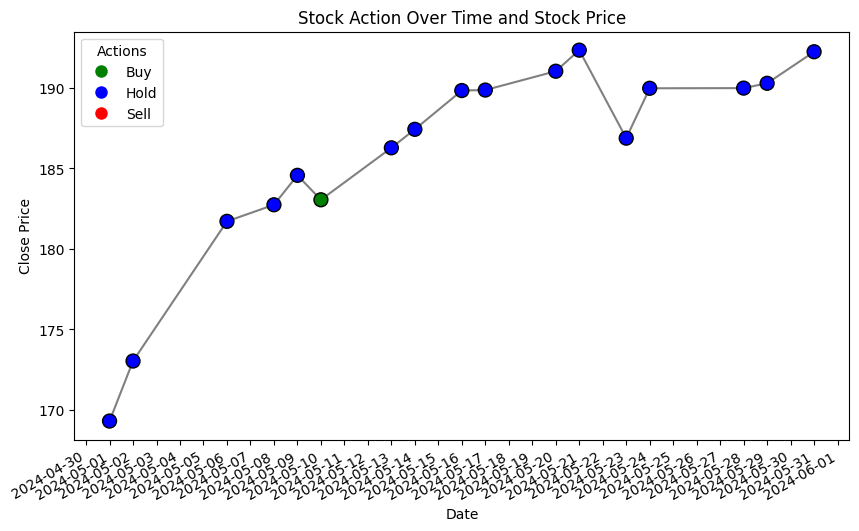

In [8]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 读取 Excel 文件
def read_apple_data(file_path):
    df = pd.read_excel(file_path)
    df['Date'] = pd.to_datetime(df['Date']).dt.date  # 转换为 datetime.date 类型
    return df

# 绘制图表函数
def plot_actions_with_stock(dates, actions, stock_data, save_path=None):
    # 打印 dates 和 actions 列表
    print("Dates:", dates)
    print("Actions:", actions)
    
    # 映射 Action 到数值
    action_map = {'Buy': 1, 'Hold': 2, 'Sell': 3}
    colors_map = {'Buy': 'green', 'Hold': 'blue', 'Sell': 'red'}
    
    # 将日期和动作映射为数值和颜色
    numeric_actions = [action_map[action] for action in actions]
    colors = [colors_map[action] for action in actions]

    # 将字符串日期转换为 datetime 对象
    dates = [datetime.strptime(date, "%Y-%m-%d").date() for date in dates]

    # 从 stock_data 中匹配日期并获取收盘价
    stock_dates = stock_data['Date'].values  # 获取股票数据的日期列

    # 过滤出存在于股票数据中的日期、动作和收盘价
    filtered_dates = []
    filtered_actions = []
    filtered_colors = []
    close_prices = []

    for i, date in enumerate(dates):
        if date in stock_dates:  # 如果日期在交易日数据中
            filtered_dates.append(date)
            filtered_actions.append(numeric_actions[i])
            filtered_colors.append(colors[i])
            close_price = stock_data.loc[stock_data['Date'] == date, 'Close'].values[0]
            close_prices.append(close_price)
        else:
            print(f"{date} 不是交易日，跳过该日期")

    # 创建图表
    fig, ax = plt.subplots(figsize=(10, 6))

    # 绘制折线图
    ax.plot(filtered_dates, close_prices, label="Close Price", color='gray', linestyle='-', marker='o', markersize=5)

    # 绘制散点图，并根据动作设置颜色
    ax.scatter(filtered_dates, close_prices, c=filtered_colors, s=100, edgecolor='black', zorder=5)

    # 设置图表标签和标题
    ax.set_title('Stock Action Over Time and Stock Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')

    # 使用 matplotlib.dates 格式化日期
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 设置日期格式
    ax.xaxis.set_major_locator(mdates.DayLocator())  # 按天显示日期

    # 自动旋转日期标签，避免重叠
    fig.autofmt_xdate()
    
    # 添加图例，表示不同的动作
    buy_patch = plt.Line2D([0], [0], marker='o', color='w', label='Buy', markerfacecolor='green', markersize=10)
    hold_patch = plt.Line2D([0], [0], marker='o', color='w', label='Hold', markerfacecolor='blue', markersize=10)
    sell_patch = plt.Line2D([0], [0], marker='o', color='w', label='Sell', markerfacecolor='red', markersize=10)
    ax.legend(handles=[buy_patch, hold_patch, sell_patch], title="Actions")
    
    # 如果提供了保存路径，则保存图表到指定路径
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)  # 保存为 PNG 格式，DPI 设置为 300
        print(f"图表已保存到 {save_path}")

    # 显示图表
    plt.show()

# 主函数
def main():
    # 文件路径
    file_path = 'APPLE.XLSX'
    
    # 读取苹果股票数据
    stock_data = read_apple_data(file_path)
    # 保存图表的路径
    save_path = 'stock_actions_normal.png'

    
    # 调用绘图函数
    plot_actions_with_stock(dates, actions, stock_data, save_path)

# 执行主函数
main()